# Pytorch study with MNIST dataset

MNIST dataset is supported by Torchvision and can be simply downloaded and converted to be Tensor as follows:

In [1]:
from torchvision import datasets, transforms

train_set = datasets.MNIST('./data/torchvision/MNIST', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor()
                          ]))

It is recommended to normalize the input data for better/robust performance of a neural network. To do so, the mean and standard deviation of the input data need to be computed, which can be done as follows.

In [2]:
def compute_trainset_stats(train_set):
    max_val = train_set.train_data.float().max().item()
    min_val = train_set.train_data.float().min().item()
    print(f'(max, min) values of pixels: {max_val}, {min_val}')

    mean_val = train_set.train_data.float().mean().item()/255
    std_val = train_set.train_data.float().std().item()/255
    print(f'(mean, std) values of pixels: {mean_val}, {std_val}')
    
    return mean_val, std_val
    
mean_val, std_val = compute_trainset_stats(train_set)

print(f'\nThe 6th line of the first train data image:\n\t{train_set[0][0][0][5]}')

(max, min) values of pixels: 255.0, 0.0
(mean, std) values of pixels: 0.1306604871562883, 0.30810780244715075

The 6th line of the first train data image:
	tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0118, 0.0706, 0.0706, 0.0706, 0.4941, 0.5333,
        0.6863, 0.1020, 0.6510, 1.0000, 0.9686, 0.4980, 0.0000, 0.0000, 0.0000,
        0.0000])


With the above mean and standard deviation, the input data can be normalized as follows.

In [3]:
train_set.transform.transforms.append(transforms.Normalize([mean_val], [std_val]))

print(f'The 6th line of the first train data image:\n\t{train_set[0][0][0][5]}')

The 6th line of the first train data image:
	tensor([-0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241, -0.4241,
        -0.4241, -0.4241, -0.4241, -0.4241, -0.3859, -0.1950, -0.1950, -0.1950,
         1.1796,  1.3069,  1.8033, -0.0931,  1.6888,  2.8215,  2.7197,  1.1924,
        -0.4241, -0.4241, -0.4241, -0.4241])


DataLoader is a convenient utility to fetch/sample data. The below shows how to create a grid of images by using make_grid function in Torchvision after multiple images are loaded by DataLoader.

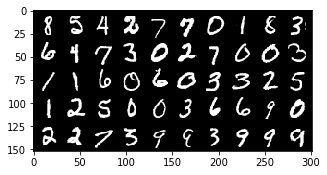

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

def imshow(image_tensor, title=None, figsize=None):
    '''
    The shape of image_tensor is C x H x W, but pyplot.imshow expects H x W x C. 
    So, the order of dimensions is changed by numpy.transpose
    '''
    image_np = image_tensor.numpy()
    
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(np.transpose(image_np, (1, 2, 0)), cmap='gray')
    if title:
        plt.title(title)
    
    plt.show()

def show_samples(dataset, gridsize=(5,10)):
    '''
    Note that nrow in make_grid is the number of images per row, i.e. the number of columns
    The normalize option in make_grid function should be set to be True. 
    Otherwise the range of image data will not be in [0, 1]
    '''
    nrow, ncol = gridsize
    sample_loader = DataLoader(dataset, batch_size=nrow*ncol, shuffle=True)

    it = iter(sample_loader)
    images, _ = it.next()
    imshow(make_grid(images, nrow=ncol, normalize=True), figsize=gridsize) 
    
show_samples(train_set)

By using the same normalization, let's prepare test dataset.

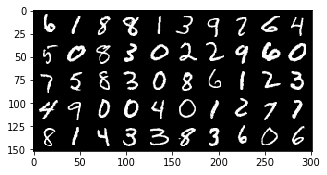

In [5]:
test_set = datasets.MNIST('./data/torchvision/MNIST', train=False, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize([mean_val], [std_val])
                          ]))

show_samples(test_set)

A simple CNN from https://github.com/pytorch/examples/blob/master/mnist/main.py will be used for this task.

To remind how to compute output dimensions of convoluation and pooling layers, the following formula were taken from http://cs231n.github.io/convolutional-networks/

* Convolution Layer
  * Input: $ D_i \times H_i \times W_i $
  * Output: $ D_o \times H_o \times W_o $
    * $D_o = K$
    * $H_o = (H_i - F + 2P)/S + 1$ 
    * $W_o = (W_i - F + 2P)/S + 1$
    * where
      * $K$: Number of filters
      * $F$: Filter's spatial extent
      * $S$: Stride
      * $P$: Amount of zero padding
* Pooling Layer
  * Input: $ D_i \times H_i \times W_i $
  * Output: $ D_o \times H_o \times W_o $
    * $D_o = D_i$
    * $H_o = (H_i - F)/S + 1$ 
    * $W_o = (W_i - F)/S + 1$
    
The below is a summary of the architecture of the model:
* Layer 1 (Convolution)
  * Input: (N, 1, 28, 28), Output: (N, 32, 26, 26)
  * (3, 3) kernel with stride (1, 1) and zero padding
  * RELU activation
* Layer 2 (Convolution)
  * Input: (N, 32, 26, 26), Output: (N, 64, 24, 24)
  * (3, 3) kernel with stride (1, 1) and zero padding
  * RELU activation
* Layer 3 (Pooling)
  * Input: (N, 64, 24, 24), Output: (N, 64, 12, 12)
  * (2, 2) kernel with stride (2, 2) and zero padding
* Layer 4 (Dropout)
  * Dropout probability: 0.25
* Layer 5 (Fully connected)
  * Input: (N, 9216 (= 64x12x12)), Output: (N, 128)
  * RELU activation
* Layer 6 (Dropout)
  * Dropout probability: 0.5
* Layer 7 (Fully connected)
  * Input: (N, 128), Output: (N, 10)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Before starting training, let's check whether a suppored GPU is available for the job. Note that device name 'cuda' indicates that GPU will be used for the task.

In [7]:
def get_device(use_gpu=False):
    if torch.cuda.is_available() and use_gpu:
        return torch.device('cuda'), True
    else:
        return torch.device('cpu'), False

device, use_gpu = get_device(use_gpu=True)
print(f'{device} will be used')

cuda will be used


The below shows how training and evaluatino per epoch can be done.

In [8]:
import torch.nn.functional as F

def train_per_epoch(model, device, train_loader, optimizer, epoch):
    '''
    Note that negative log likelihood loss function (nll_loss) is used here. 
    Also, reduction='sum' is used in the loss function instead of 'mean' because losses from the whole data set
    will be computed and summed up first to compute the overall mean at the end.
    '''
    model.train() # set the model in training mode
    total_num_data = len(train_loader.dataset)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) # put data in right memory, i.e. main or GPU memory
        optimizer.zero_grad() # clear all gradients
        output = model(data) # perform single forward path calculation
        loss = F.nll_loss(output, target) # compute loss
        loss.backward() # compute gradients for all parameters
        optimizer.step() # update all parameters
        if batch_idx % 10 == 0:
            num_processed_data = batch_idx * len(data)
            print(f'Train Epoch: {epoch} [{num_processed_data}/{total_num_data}]', end='\t')
            print(f'Loss: {loss.item():.6f}')

def test_per_epoch(model, device, test_loader):
    model.eval() # set the model in evaluation mode. In this mode, some layers (e.g. dropout) work differently.
    total_num_data = len(test_loader.dataset)
    
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) # put data in right memory, i.e. main or GPU memory
            output = model(data) # perform single forward path calculation
            test_loss += F.nll_loss(output, target, reduction='sum').item() # compute the loss
            pred = output.argmax(dim=1, keepdim=True) # get the predictions
            correct += pred.eq(target.view_as(pred)).sum().item() # compare the predictions and the labels
            
    test_loss /= total_num_data
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total_num_data}\n')

In the process of loading train/test data into memory by using DataLoader, it can be selected whether data will be loaded into pinned memory instead of pageable memory. In short, loading into pinned memory improves data transfer from main memory to GPU memory. For more details, refer to https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/

In [9]:
train_batch_size = 256
test_batch_size = 256

train_loader = torch.utils.data.DataLoader(train_set, batch_size=train_batch_size, shuffle=True, pin_memory=use_gpu)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, pin_memory=use_gpu)

Let's train the model.

To run the training job, there are two more things to be specified, gradient descent optimization algorithm and learning rate schedule. For example, [Adadelta](https://pytorch.org/docs/stable/optim.html?highlight=adadelta#torch.optim.Adadelta) can be used as a gradient descent optimization algorithm and [StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) can be used as a learning rate schedule.

In [10]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

num_epoch = 3

model = Model().to(device) # store model information in the device used for computation

optimizer = optim.Adadelta(model.parameters(), lr=1)

scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
for epoch in range(1, num_epoch + 1):
    print(f'Current learning rate = {scheduler.get_lr()}')
    train_per_epoch(model, device, train_loader, optimizer, epoch)
    test_per_epoch(model, device, test_loader)
    scheduler.step()

Current learning rate = [1.0]
Train Epoch: 1 [0/60000]	Loss: 2.307776
Train Epoch: 1 [2560/60000]	Loss: 1.298858
Train Epoch: 1 [5120/60000]	Loss: 1.211867
Train Epoch: 1 [7680/60000]	Loss: 0.414543
Train Epoch: 1 [10240/60000]	Loss: 0.302826
Train Epoch: 1 [12800/60000]	Loss: 0.198771
Train Epoch: 1 [15360/60000]	Loss: 0.209185
Train Epoch: 1 [17920/60000]	Loss: 0.257266
Train Epoch: 1 [20480/60000]	Loss: 0.249905
Train Epoch: 1 [23040/60000]	Loss: 0.229756
Train Epoch: 1 [25600/60000]	Loss: 0.150722
Train Epoch: 1 [28160/60000]	Loss: 0.127661
Train Epoch: 1 [30720/60000]	Loss: 0.216504
Train Epoch: 1 [33280/60000]	Loss: 0.119622
Train Epoch: 1 [35840/60000]	Loss: 0.148081
Train Epoch: 1 [38400/60000]	Loss: 0.154479
Train Epoch: 1 [40960/60000]	Loss: 0.124287
Train Epoch: 1 [43520/60000]	Loss: 0.111786
Train Epoch: 1 [46080/60000]	Loss: 0.257656
Train Epoch: 1 [48640/60000]	Loss: 0.139574
Train Epoch: 1 [51200/60000]	Loss: 0.138665
Train Epoch: 1 [53760/60000]	Loss: 0.081462
Train Epo